### Imports & Setup

In [69]:
import json
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MAX_OBJECTS = 10
OBJ_DIM = 18      # approx, based on encoding
Q_EMBED_DIM = 128
HIDDEN_DIM = 128
BATCH_SIZE = 64
LR = 1e-3

### Load Data

In [ ]:
QUESTIONS_PATH = "data/CLEVR_v1.0/questions/CLEVR_train_questions.json"
SCENES_PATH = "data/CLEVR_v1.0/scenes/CLEVR_train_scenes.json"

questions_all  = json.load(open(QUESTIONS_PATH))["questions"]
scenes_json = json.load(open(SCENES_PATH))["scenes"]
scenes = {s["image_index"]: s for s in scenes_json}

# Subsample for fast iteration
random.shuffle(questions_all)
questions_json = questions_all[:20000]

program_lookup = {
    q["question_index"]: q.get("program", [])
    for q in questions_all
}

split = int(0.8 * len(questions_all))
train_questions = questions_all[:split]
val_questions   = questions_all[split:]


### Define Vocab class and helper functions

In [15]:
class Vocab:
    def __init__(self, questions):
        self.word2idx = {"<pad>": 0}
        self.idx2word = ["<pad>"]
        self.answer2idx = {}
        self.idx2answer = []

        for q in questions:
            for w in q["question"].lower().split():
                if w not in self.word2idx:
                    self.word2idx[w] = len(self.idx2word)
                    self.idx2word.append(w)

            a = q["answer"]
            if a not in self.answer2idx:
                self.answer2idx[a] = len(self.idx2answer)
                self.idx2answer.append(a)

    def encode_question(self, text):
        return torch.tensor(
            [self.word2idx[w] for w in text.lower().split()],
            dtype=torch.long
        )

    def encode_answer(self, ans):
        return self.answer2idx[ans]


In [46]:
vocab = Vocab(questions_all)
NUM_ANSWERS = len(vocab.idx2answer)
VOCAB_SIZE = len(vocab.idx2word)

### Define dataset and collate functions

In [47]:
class CLEVRDataset(Dataset):
    def __init__(self, questions, scenes, vocab):
        self.questions = questions
        self.scenes = scenes
        self.vocab = vocab

        self.colors = ["gray","red","blue","green","brown","purple","cyan","yellow"]
        self.shapes = ["cube","sphere","cylinder"]
        self.sizes = ["small","large"]
        self.materials = ["rubber","metal"]

    def encode_object(self, obj):
        vec = []
        vec += [obj["color"] == c for c in self.colors]
        vec += [obj["shape"] == s for s in self.shapes]
        vec += [obj["size"] == s for s in self.sizes]
        vec += [obj["material"] == m for m in self.materials]
        vec += obj["3d_coords"]
        return torch.tensor(vec, dtype=torch.float)

    def __getitem__(self, idx):
        q = self.questions[idx]
        scene = self.scenes[q["image_index"]]

        objs = [self.encode_object(o) for o in scene["objects"]]

        while len(objs) < MAX_OBJECTS:
            objs.append(torch.zeros_like(objs[0]))

        objs = torch.stack(objs[:MAX_OBJECTS])
        question = self.vocab.encode_question(q["question"])
        answer = self.vocab.encode_answer(q["answer"])

        return objs, question, answer

    def __len__(self):
        return len(self.questions)


In [55]:
def collate_fn(batch):
    objects, questions, answers = zip(*batch)

    objects = torch.stack(objects)
    answers = torch.tensor(answers)

    lengths = [len(q) for q in questions]
    max_len = max(lengths)

    padded_q = torch.zeros(len(questions), max_len, dtype=torch.long)
    for i, q in enumerate(questions):
        padded_q[i, :len(q)] = q

    return objects, padded_q, answers

def reasoning_depth(program):
    return len(program)


### Define question encoder

In [56]:
class QuestionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(VOCAB_SIZE, Q_EMBED_DIM)
        self.gru = nn.GRU(Q_EMBED_DIM, Q_EMBED_DIM, batch_first=True)

    def forward(self, q):
        emb = self.embed(q)
        _, h = self.gru(emb)
        return h.squeeze(0)

### Baseline Model

In [57]:
class BagOfObjects(nn.Module):
    def __init__(self):
        super().__init__()
        self.obj_proj = nn.Linear(OBJ_DIM, HIDDEN_DIM)
        self.att = nn.Linear(HIDDEN_DIM + Q_EMBED_DIM, 1)
        self.classifier = nn.Linear(HIDDEN_DIM, NUM_ANSWERS)

    def forward(self, objs, q):
        h = self.obj_proj(objs)

        q_exp = q.unsqueeze(1).expand(-1, h.size(1), -1)
        a = self.att(torch.cat([h, q_exp], dim=-1)).squeeze(-1)
        a = torch.softmax(a, dim=1)

        pooled = (a.unsqueeze(-1) * h).sum(dim=1)
        return self.classifier(pooled)

### LCGN Model

In [58]:
class LCGNCore(nn.Module):
    def __init__(self, obj_dim, q_dim, hidden_dim, T=3):
        super().__init__()
        self.T = T

        # Initial object projection
        self.obj_proj = nn.Linear(obj_dim, hidden_dim)
        # Message function
        self.msg_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + q_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # Node update
        self.update_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU()
        )

        # Language-conditioned edge attention
        self.edge_att = nn.Linear(hidden_dim * 2 + q_dim, 1)

    def forward(self, objs, q):
        B, N, _ = objs.shape

        # Initial node states
        h = self.obj_proj(objs)

        for _ in range(self.T):
            h_i = h.unsqueeze(2).expand(-1, -1, N, -1)
            h_j = h.unsqueeze(1).expand(-1, N, -1, -1)
            q_exp = q.unsqueeze(1).unsqueeze(2).expand(-1, N, N, -1)

            # Pairwise features
            pair = torch.cat([h_i, h_j, q_exp], dim=-1)
            # Attention weights
            att = self.edge_att(pair).squeeze(-1)
            att = torch.softmax(att, dim=2)
            # Messages
            msg = self.msg_mlp(pair)
            msg = (att.unsqueeze(-1) * msg).sum(dim=2)
            # Update nodes
            h = self.update_mlp(torch.cat([h, msg], dim=-1))
        
        return h
    
class LCGNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.core = LCGNCore(OBJ_DIM, Q_EMBED_DIM, HIDDEN_DIM, T=3)
        self.classifier = nn.Linear(HIDDEN_DIM, NUM_ANSWERS)

    def forward(self, objs, q):
        h = self.core(objs, q)
        pooled = h.mean(dim=1)
        return self.classifier(pooled)

### Evaluation

In [59]:
MAX_TRAIN_DEPTH = 4

train_short = [
    q for q in train_questions
    if len(program_lookup[q["question_index"]]) <= MAX_TRAIN_DEPTH
]

val_long = [
    q for q in val_questions
    if len(program_lookup[q["question_index"]]) > MAX_TRAIN_DEPTH
]

print(len(train_questions), len(val_questions))
print(len(train_short), len(val_long))

depth_groups = defaultdict(list)

for q in val_questions:
    d = reasoning_depth(program_lookup[q["question_index"]])
    depth_groups[d].append(q)

for d in sorted(depth_groups):
    print(f"Depth {d}: {len(depth_groups[d])} questions")

559991 139998
9534 137557
Depth 2: 30 questions
Depth 3: 371 questions
Depth 4: 2040 questions
Depth 5: 6853 questions
Depth 6: 10558 questions
Depth 7: 10828 questions
Depth 8: 15925 questions
Depth 9: 17234 questions
Depth 10: 9911 questions
Depth 11: 6426 questions
Depth 12: 6713 questions
Depth 13: 7228 questions
Depth 14: 9085 questions
Depth 15: 9931 questions
Depth 16: 8593 questions
Depth 17: 6126 questions
Depth 18: 4545 questions
Depth 19: 3463 questions
Depth 20: 2245 questions
Depth 21: 1310 questions
Depth 22: 461 questions
Depth 23: 103 questions
Depth 24: 18 questions
Depth 25: 1 questions


In [60]:
def evaluate_by_depth(model, q_encoder, depth_groups):
    model.eval()
    q_encoder.eval()

    depth_loss = {}

    with torch.no_grad():
        for d, qs in depth_groups.items():
            if len(qs) < 50:   # avoid noise
                continue

            dataset = CLEVRDataset(qs, scenes, vocab)
            loader = DataLoader(
                dataset,
                batch_size=64,
                shuffle=False,
                collate_fn=collate_fn
            )

            total_loss = 0
            for objs, q, ans in loader:
                objs, q, ans = objs.to(DEVICE), q.to(DEVICE), ans.to(DEVICE)
                logits = model(objs, q_encoder(q))
                loss = nn.functional.cross_entropy(logits, ans)
                total_loss += loss.item()

            depth_loss[d] = total_loss / len(loader)

    return depth_loss

### Training Loop

In [65]:
def evaluate(model, q_encoder, questions):
    model.eval()
    q_encoder.eval()

    dataset = CLEVRDataset(questions, scenes, vocab)
    loader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=collate_fn
    )

    total_loss = 0
    with torch.no_grad():
        for objs, q, ans in loader:
            objs, q, ans = objs.to(DEVICE), q.to(DEVICE), ans.to(DEVICE)
            q_vec = q_encoder(q)
            logits = model(objs, q_vec)
            loss = nn.functional.cross_entropy(logits, ans)
            total_loss += loss.item()

    return total_loss / len(loader)

In [61]:
dataset = CLEVRDataset(questions_json, scenes, vocab)
loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                    shuffle=True, collate_fn=collate_fn)

q_encoder = QuestionEncoder().to(DEVICE)
#model = BagOfObjects().to(DEVICE)
model = LCGNModel().to(DEVICE)

opt = torch.optim.Adam(
    list(q_encoder.parameters()) + list(model.parameters()), lr=LR
)

for epoch in range(5):
    total = 0
    for objs, q, ans in loader:
        objs, q, ans = objs.to(DEVICE), q.to(DEVICE), ans.to(DEVICE)

        q_vec = q_encoder(q)
        logits = model(objs, q_vec)
        loss = nn.functional.cross_entropy(logits, ans)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item()

    print(f"Epoch {epoch}: loss={total/len(loader):.3f}")

Epoch 0: loss=1.947
Epoch 1: loss=1.093
Epoch 2: loss=1.031
Epoch 3: loss=1.013
Epoch 4: loss=1.009


### Train only on Short Programs (Stress Test Generalization)

In [63]:
dataset = CLEVRDataset(train_short, scenes, vocab)
loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                    shuffle=True, collate_fn=collate_fn)

q_encoder = QuestionEncoder().to(DEVICE)
model = LCGNModel().to(DEVICE)

opt = torch.optim.Adam(
    list(q_encoder.parameters()) + list(model.parameters()), lr=LR
)

for epoch in range(5):
    total = 0
    for objs, q, ans in loader:
        objs, q, ans = objs.to(DEVICE), q.to(DEVICE), ans.to(DEVICE)

        q_vec = q_encoder(q)
        logits = model(objs, q_vec)
        loss = nn.functional.cross_entropy(logits, ans)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item()

    print(f"Epoch {epoch}: loss={total/len(loader):.3f}")

Epoch 0: loss=1.771
Epoch 1: loss=1.084
Epoch 2: loss=1.018
Epoch 3: loss=0.996
Epoch 4: loss=0.980


In [66]:
short_loss = evaluate(model, q_encoder, train_short[:2000])
print(f"Short-program loss: {short_loss:.3f}")

long_loss = evaluate(model, q_encoder, val_long)
print(f"Long-program loss: {long_loss:.3f}")

Short-program loss: 0.974
Long-program loss: 6.029


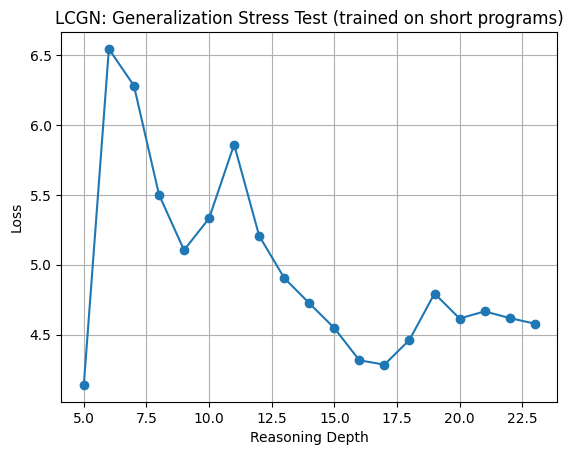

In [70]:
depth_loss_long = {}
for d, qs in depth_groups.items():
    # skip depths with <20 questions or in training
    if len(qs) < 20 or d <= MAX_TRAIN_DEPTH:
        continue
    depth_loss_long[d] = evaluate(model, q_encoder, qs)

# Plot
plt.plot(sorted(depth_loss_long.keys()), [depth_loss_long[d] for d in sorted(depth_loss_long.keys())], marker='o')
plt.xlabel("Reasoning Depth")
plt.ylabel("Loss")
plt.title("LCGN: Generalization Stress Test (trained on short programs)")
plt.grid(True)
plt.show()

In [ ]:
depth_loss = evaluate_by_depth(model, q_encoder, depth_groups)

for d in sorted(depth_loss):
    print(f"Depth {d}: loss = {depth_loss[d]:.3f}")

Depth 3: loss = 1.251
Depth 4: loss = 1.007
Depth 5: loss = 1.067
Depth 6: loss = 1.085
Depth 7: loss = 1.051
Depth 8: loss = 1.048
Depth 9: loss = 1.058
Depth 10: loss = 1.029
Depth 11: loss = 0.926
Depth 12: loss = 0.962
Depth 13: loss = 1.014
Depth 14: loss = 0.972
Depth 15: loss = 0.927
Depth 16: loss = 0.911
Depth 17: loss = 0.908
Depth 18: loss = 0.884
Depth 19: loss = 0.809
Depth 20: loss = 0.756
Depth 21: loss = 0.723
Depth 22: loss = 0.712
Depth 23: loss = 0.730
